<a href="https://colab.research.google.com/github/jjliewie/DeepFakeDetection/blob/main/DeepFake_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Overall System Architecture
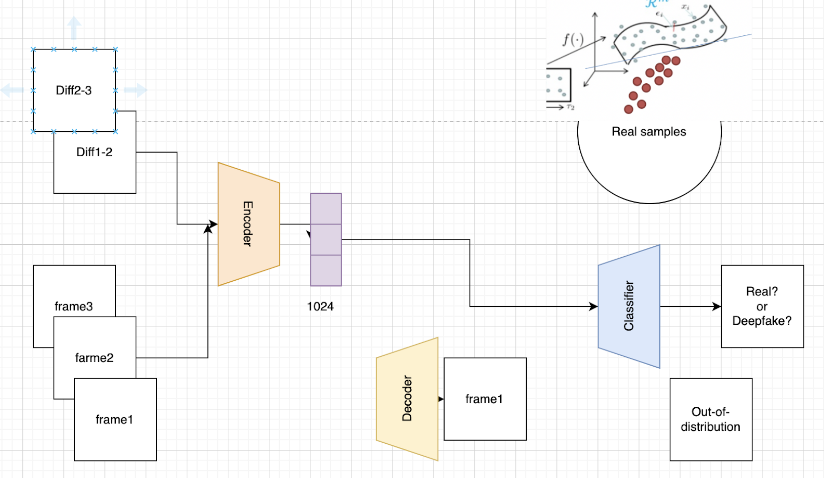

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

import numpy as np

torch.cuda.is_available()

True

In [ ]:
# classifier
class DeepFakeClassifier(nn.Module):
  def __init__(self, in_feature, out_feature):

    super(DeepFakeClassifier, self).__init__()

    self.in_feature = in_feature # number of input features
    self.out_feature = out_feature # number of output features (2)

    self.linear1 = nn.Linear(self.in_feature, 100)
    self.linear2 = nn.Linear(100, self.out_feature)

    self.relu = nn.ReLU() # activation function

  def forward(self, x): # x : input data
    x = self.linear1(x)
    x = self.relu(x)

    x = self.linear2(x)

    return x

In [ ]:
model = DeepFakeClassifier(1024, 2)
model = model.cuda()

dummy_input = torch.randn(1, 1024)
dummy_input = dummy_input.cuda()

pred = model(dummy_input)
print(pred)

idx2class = {
    0 : 'Real', 
    1 : 'Fake'
}

print( idx2class[ int(pred.argmax(dim=1)) ] )

tensor([[ 0.3720, -0.2070]], device='cuda:0', grad_fn=<AddmmBackward0>)
Real


In [ ]:
class DeepFakeAutoEncoder(nn.Module):
  def __init__(self):

    super(DeepFakeAutoEncoder, self).__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1), 
        nn.ReLU(), 
        nn.Conv2d(32, 64, kernel_size =3, padding=1), 
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3, padding=1), 
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(), 
        nn.Conv2d(256, 256, kernel_size=3, padding=1), 
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.ReLU(), 
        nn.Conv2d(512, 512, kernel_size=3, padding=1), 
        nn.ReLU(),
        nn.MaxPool2d(2,2),
    )

    self.decoder = nn.Sequential(
        nn.Conv2d(512, 256, kernel_size=3, padding=1),
        nn.ReLU(),

        nn.Upsample(scale_factor=2, mode='bilinear'),
        nn.Conv2d(256, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),

        nn.Upsample(scale_factor=2, mode='bilinear'),
        nn.Conv2d(128, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),

        nn.Upsample(scale_factor=2, mode='bilinear'),
        nn.Conv2d(64, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),

        nn.Conv2d(32, 3, kernel_size=3, padding=1),
    )

  def forward(self, x):
    latent_variable = self.encoder(x)
    y = self.decoder(latent_variable)
    return y

In [ ]:
autoencoder = DeepFakeAutoEncoder()
autoencoder = autoencoder.cuda()

dummy_image = torch.randn(1, 3, 224, 224)
dummy_image = dummy_image.cuda()

reconstructed_image = autoencoder(dummy_image)

print(reconstructed_image.shape)

torch.Size([1, 3, 224, 224])


1. dataset load (image load)
2. numpy type -> torch.tensor type
3. image resize (224, 224)
4. data augumentation
5. ground truth load

In [ ]:
class DeepFakeDataset(Dataset):
  def __init__(self, image_dir, transform):
    super(DeepFakeDataset, self).__init__()

    self.image_dir = image_dir
    self.transform = transform

    self.samples = ['real1', 'real2', 'fake3', 'fake4']
    self.gt = [0, 0, 1, 1] # ground truth

  def __len__(self):
    return len(self.samples)
  
  def __getitem__(self, idx):
    # sample = self.samples[idx]
    # sample = torch.randn(3, 224, 224)

    sample = np.ones((3, 224, 224)).astype(np.float32)

    sample = self.transform(sample)

    gt = torch.LongTensor([self.gt[idx]]).squeeze()
    return sample, gt

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

my_dataset = DeepFakeDataset('abc', transform)
len(my_dataset)

for x, y in my_dataset:
  print(x.shape, y)

torch.Size([224, 3, 224]) tensor(0)
torch.Size([224, 3, 224]) tensor(0)
torch.Size([224, 3, 224]) tensor(1)
torch.Size([224, 3, 224]) tensor(1)


In [ ]:
# get file from computer
from google.colab import files
uploaded = files.upload()
my_data = 'deepfake1.png'

KeyboardInterrupt: ignored

In [ ]:
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img = Image.open(my_data)

transformed_img = transform(img)

print(transformed_img.shape)

torch.Size([4, 224, 224])


In [ ]:
model1 = DeepFakeAutoEncoder()
model1 = model1.cuda()

transformed_img = transformed_img.view(1, 3, 224, 224)
# transformed_img = transformed_img[:, 0:3, :, :]
transformed_img = transformed_img.cuda()

reconstructed_img = model1(transformed_img)

print(reconstructed_img.shape)

torch.Size([1, 3, 224, 224])


11000 -> 0.000553825288079679
21000 -> 0.32643136382102966
31000 -> 0.017311351373791695
41000 -> 0.021467134356498718
51000 -> 0.07049122452735901
61000 -> 0.09812521189451218
71000 -> 0.1078813225030899
81000 -> 0.10799472779035568
91000 -> 0.10286162048578262
101000 -> 0.09358984977006912
111000 -> 0.08090513199567795
121000 -> 0.06545927375555038
131000 -> 0.04797787219285965
141000 -> 0.031219014897942543
151000 -> 0.01977011002600193
161000 -> 0.019120030105113983
171000 -> 0.030474785715341568
181000 -> 0.04280942678451538
191000 -> 0.04246241971850395
201000 -> 0.030449889600276947
211000 -> 0.018117206171154976
221000 -> 0.0123750614002347
231000 -> 0.012995962984859943
241000 -> 0.0166623555123806
251000 -> 0.020288798958063126
261000 -> 0.022097855806350708
271000 -> 0.021235045045614243
281000 -> 0.018207566812634468
291000 -> 0.014036089181900024
301000 -> 0.01025223359465599
311000 -> 0.00854886882007122
321000 -> 0.009762476198375225
331000 -> 0.012350683100521564
341000

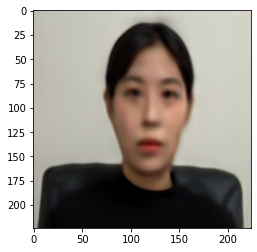

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

optimizer = torch.optim.Adam(
    model1.parameters(), lr=1e-4
)

loss_fn = torch.nn.MSELoss() # Mean Squared Error

MAX_EPOCH = 1000

model1.train()
fig = plt.gcf()

for ep in range(1, MAX_EPOCH + 1):
  gt = transformed_img.clone()
  pred = model1(transformed_img)

  loss = loss_fn(pred, gt)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  print('{}{} -> {}'.format(ep, MAX_EPOCH, loss.item()))

  if ep % 20 == 0:
    pred = pred.view(3, 224, 224).cpu().detach()
    np_img = (pred * 255.0).clamp_(0, 255).numpy().astype(np.uint8).transpose(1, 2, 0)
    plt.imshow(np_img)
